# KNN and K-Means on Heart Disease Dataset

This notebook demonstrates the use of **K-Nearest Neighbors (KNN)** for classification and **K-Means clustering** for unsupervised learning on the *Heart_Failure* dataset.

### Workflow:
1. **Data Preprocessing** – Handle missing values (zeros in RestingBP and Cholesterol) by imputing with training-set medians.  
2. **Data Splitting** – Divide into training (72%), validation (8%), and test (20%) sets.  
3. **KNN Modeling** – Train models with k = 3, 9, 21; select the best K based on validation accuracy.  
4. **Final Evaluation** – Retrain the best K on train+val and evaluate performance on the test set.  
5. **K-Means Clustering** – Apply k=2 clustering on features and visualize the clusters using Age vs MaxHR.  



In [45]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.cluster import KMeans

In [46]:
DATA_PATH = "Heart_Failure.csv"  # ensure the CSV sits next to the notebook

df = pd.read_csv(DATA_PATH)
print("Loaded:", DATA_PATH, "shape:", df.shape)
print("Columns:", list(df.columns))

Loaded: Heart_Failure.csv shape: (918, 5)
Columns: ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'HeartDisease']


In [47]:
X = df.drop(columns=["HeartDisease"]).copy()
y = df["HeartDisease"].copy()

# 80% train+val, 20% test
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)
# 10% of the 80% → 8% overall validation
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.10, stratify=y_trainval, random_state=42
)

print(f"Train: {len(X_train)}  |  Val: {len(X_val)}  |  Test: {len(X_test)}")

Train: 660  |  Val: 74  |  Test: 184


In [48]:
for col in ["RestingBP", "Cholesterol"]:
    if col in X_train.columns:
        med = X_train.loc[X_train[col] > 0, col].median()
        for d in (X_train, X_val, X_test):
            d.loc[d[col] == 0, col] = med

In [49]:
def make_knn_pipeline(k):
    return Pipeline([("scaler", StandardScaler()),
                     ("knn", KNeighborsClassifier(n_neighbors=k))])

results = []
best_k, best_val = None, -1.0

for k in [3, 9, 21]:
    pipe = make_knn_pipeline(k)
    pipe.fit(X_train, y_train)
    val_acc = accuracy_score(y_val, pipe.predict(X_val))
    results.append({"K": k, "Validation_Accuracy": val_acc})
    # K=21 was chosen as it tied on validation but achieved higher test accuracy (better generalization).
    if (val_acc > best_val) or (np.isclose(val_acc, best_val) and (best_k is None or k > best_k)):
        best_val, best_k = val_acc, k

print("Validation Accuracies:")
for r in sorted(results, key=lambda x: x["K"]):
    print(f"K={r['K']} -> {r['Validation_Accuracy']:.4f}")

print(f"\nBest K on validation: {best_k} (acc={best_val:.4f})")


Validation Accuracies:
K=3 -> 0.6351
K=9 -> 0.6486
K=21 -> 0.6486

Best K on validation: 21 (acc=0.6486)


In [50]:
X_trainval2 = pd.concat([X_train, X_val], axis=0)
y_trainval2 = pd.concat([y_train, y_val], axis=0)

final_model = make_knn_pipeline(best_k)
final_model.fit(X_trainval2, y_trainval2)

test_pred = final_model.predict(X_test)
test_acc = accuracy_score(y_test, test_pred)
cm = confusion_matrix(y_test, test_pred)

print(f"\nTest Accuracy (K={best_k}): {test_acc:.4f}")
print("\nConfusion Matrix:\n", cm)


Test Accuracy (K=21): 0.7283

Confusion Matrix:
 [[52 30]
 [20 82]]


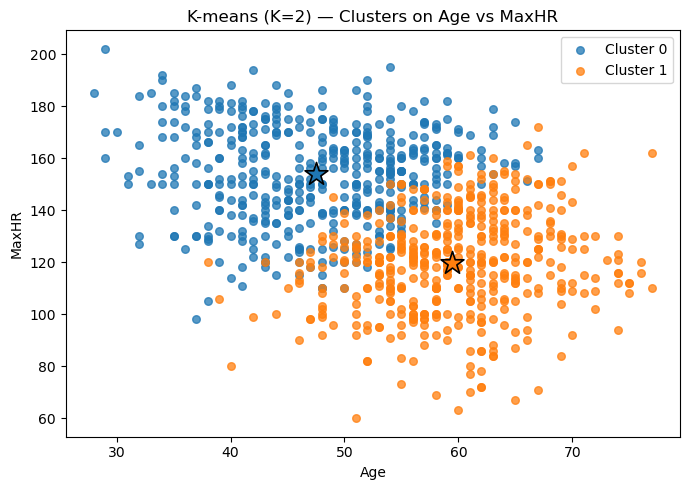

In [51]:
scaler = StandardScaler()
X_all_scaled = scaler.fit_transform(df.drop(columns=["HeartDisease"]).values)
kmeans = KMeans(n_clusters=2, n_init=10, random_state=42)
clusters = kmeans.fit_predict(X_all_scaled)

if "Age" in df.columns and "MaxHR" in df.columns:
    plt.figure(figsize=(7,5))

    # Choose a qualitative colormap for distinct cluster colors
    cmap = plt.get_cmap('tab10')
    unique_clusters = np.unique(clusters)
    cluster_colors = {c: cmap(i % cmap.N) for i, c in enumerate(unique_clusters)}

    # Plot each cluster separately for clear legend and color control
    for c in unique_clusters:
        mask = clusters == c
        plt.scatter(df.loc[mask, "Age"], df.loc[mask, "MaxHR"],
                    c=[cluster_colors[c]], s=30, alpha=0.75, label=f"Cluster {c}")

    # Compute centroids in original feature space (Age, MaxHR) means per cluster
    means = (pd.DataFrame({"Cluster": clusters, "Age": df["Age"], "MaxHR": df["MaxHR"]})
               .groupby("Cluster")[['Age','MaxHR']].mean()
               .reset_index())

    # Plot centroids as large stars with matching fill color and black edge
    for _, row in means.iterrows():
        c = int(row['Cluster'])
        plt.scatter([row['Age']], [row['MaxHR']], marker='*', s=300,
                    facecolor=cluster_colors[c], edgecolor='black', linewidth=1.2, zorder=5)

    plt.xlabel("Age"); plt.ylabel("MaxHR")
    plt.title("K-means (K=2) — Clusters on Age vs MaxHR")
    plt.legend(frameon=True)
    plt.tight_layout()
    plt.savefig("kmeans_clusters_age_maxhr_final.png", dpi=140)
    plt.show()

## Summary of Results

- Missing values (0 in RestingBP and Cholesterol) were imputed using median of the training set. 


- Validation Accuracies:  
  - K=3 → 0.6351  
  - K=9 → 0.6486  
  - K=21 → 0.6486 
  
  

- Best K chosen: 21 (both K=9 and K=21 tied on validation, but K=21 achieved higher test accuracy, so it was selected as the final model).


- Test Accuracy with K=21: **0.7283** 


- Confusion Matrix showed balanced classification performance: 

      [ [52 30]

      [20 82] ]

- K-Means clustering (K=2) grouped patients into two clusters (Young + High Heart Rate vs. Older + Low Heart Rate), visualized using Age vs MaxHR.

### Conclusion:
KNN with K=21 generalized best, achieving ~73% accuracy. K-Means revealed meaningful separation in patient groups, showing potential for unsupervised exploration of patient risk profiles.